<a href="https://colab.research.google.com/github/eviatarbach/variational_filtering/blob/main/Kuramoto_Sivashinsky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pickle
from jax import random
from jax import jit
from jax.scipy.linalg import svd
import jax

In [12]:
import pickle
import matplotlib.pyplot as plt
import os
import glob

directory = '/central/home/eluk/variational_filtering/experiment_data/'

# List all files in the directory 
files = glob.glob(os.path.join(directory, '*.pkl'))

if files:
    most_recent_file = max(files, key=os.path.getmtime)
    print(f"Most recent file: {most_recent_file}")

    most_recent_file = '/central/home/eluk/variational_filtering/experiment_data/l96_experiment_2024-03-24_20-52-09.pkl'


    with open(most_recent_file, 'rb') as f:
        loaded_data = pickle.load(f)
else:
    print("No files found in the specified directory.")

Most recent file: /central/home/eluk/variational_filtering/experiment_data/ks_experiment_2024-03-30_23-54-31.pkl


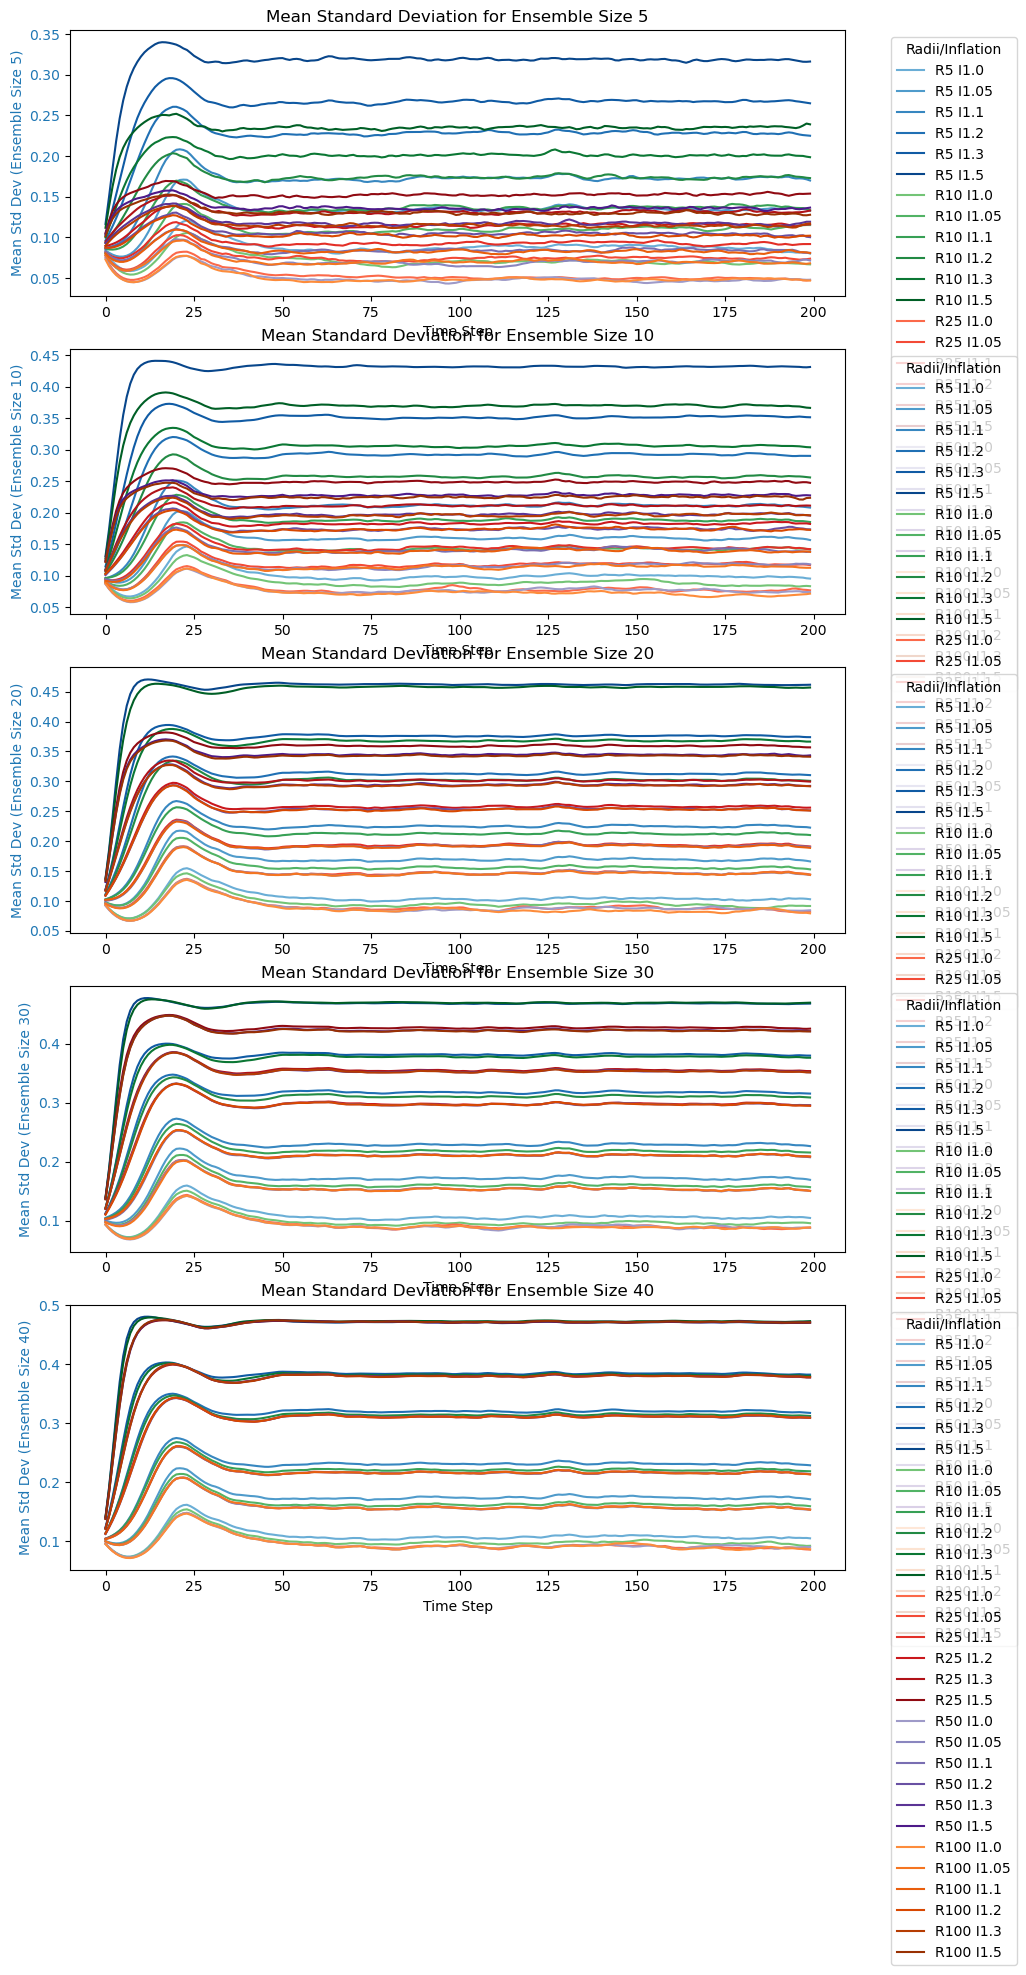

In [13]:
std_errors = loaded_data['std_errors']
errors = loaded_data['errors']
parameters = loaded_data['parameters']


radii = parameters['radii']
inflations = parameters['inflations']
ensemble_sizes = parameters['ensemble_sizes']
num_trials = parameters['num_trials']


mean_std_errors = {(radius, inflation, n_ensemble): jnp.mean(jnp.vstack(std_errors[(radius, inflation, n_ensemble)]), axis=0)
                   for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}
mean_errors = {(radius, inflation, n_ensemble): jnp.mean(jnp.vstack(errors[(radius, inflation, n_ensemble)]), axis=0)
               for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}


num_ensemble_sizes = len(ensemble_sizes)
fig, axs = plt.subplots(num_ensemble_sizes, 1, figsize=(10, num_ensemble_sizes * 4))  # Adjust figsize as needed

base_colors = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges']

# Check if we have more than one subplot to iterate correctly
if num_ensemble_sizes > 1:
    ax_iter = axs.flat
else:
    ax_iter = [axs]

for ax, n_ensemble in zip(ax_iter, ensemble_sizes):
    for radius_index, radius in enumerate(radii[1:]):
        cmap = plt.colormaps.get_cmap(base_colors[radius_index])
        num_inflations = len(inflations)
        colors = [cmap(0.5 + i / (2 * num_inflations)) for i in range(num_inflations)]

        for inflation_index, inflation in enumerate(inflations):
            color = colors[inflation_index]
            label = f"R{radius} I{inflation}"
            mean_std = mean_std_errors[(radius, inflation, n_ensemble)]
            ax.plot(mean_std, label=label, color=color)

    ax.set_xlabel('Time Step')
    ax.set_ylabel(f'Mean Std Dev (Ensemble Size {n_ensemble})', color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.legend(title='Radii/Inflation', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title(f"Mean Standard Deviation for Ensemble Size {n_ensemble}")

plt.show()


In [4]:
print(std_errors[list(std_errors.keys())[0]][0].shape)


print(std_errors[list(std_errors.keys())[0]][1][0])


(200,)
0.017718583


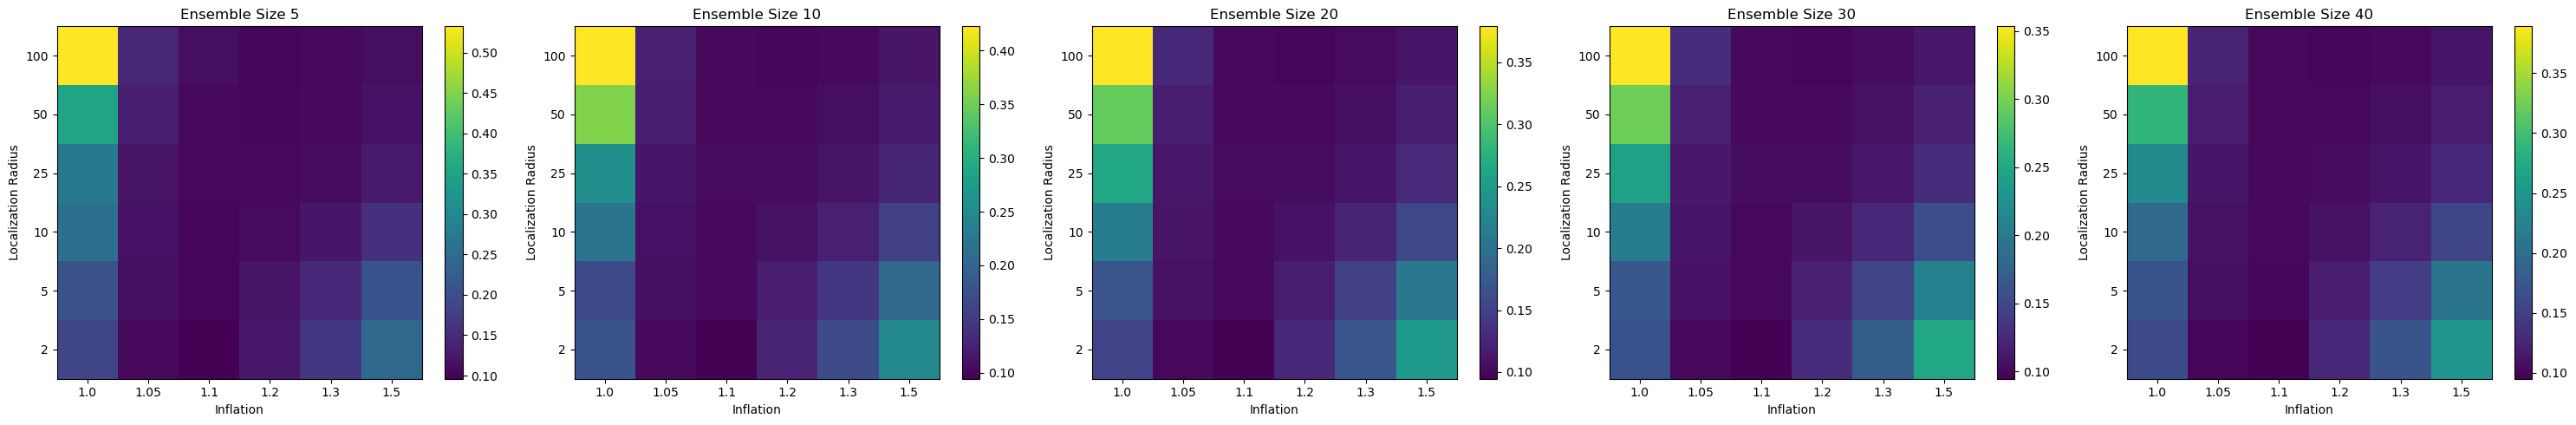

In [5]:
import jax.numpy as np
import jax.numpy as jnp
total_errors = {(radius, inflation, n_ensemble): jnp.mean(mean_errors[(radius, inflation, n_ensemble)]) for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}

num_ensemble_sizes = len(ensemble_sizes)
fig, axs = plt.subplots(1, num_ensemble_sizes, figsize=(num_ensemble_sizes * 6, 5))

if num_ensemble_sizes == 1:
    axs = [axs]

for idx, n_ensemble in enumerate(ensemble_sizes):
    if n_ensemble == 30:
        continue
    # Create a matrix to store total errors for heatmap plotting
    error_matrix = jnp.zeros((len(radii), len(inflations)))

    for i, radius in enumerate(radii):
        for j, inflation in enumerate(inflations):
            error_matrix = error_matrix.at[i, j].set(total_errors[(radius, inflation, n_ensemble)])

    # Plotting
    cax = axs[idx].imshow(error_matrix, cmap='viridis', origin='lower', aspect='auto')
    axs[idx].set_title(f'Ensemble Size {n_ensemble}')
    axs[idx].set_xticks(jnp.arange(len(inflations)))
    axs[idx].set_yticks(jnp.arange(len(radii)))
    axs[idx].set_xticklabels(inflations)
    axs[idx].set_yticklabels(radii)
    axs[idx].set_xlabel('Inflation')
    axs[idx].set_ylabel('Localization Radius')

    # Adding colorbar to each subplot
    fig.colorbar(cax, ax=axs[idx], orientation='vertical')

plt.tight_layout()
plt.show()


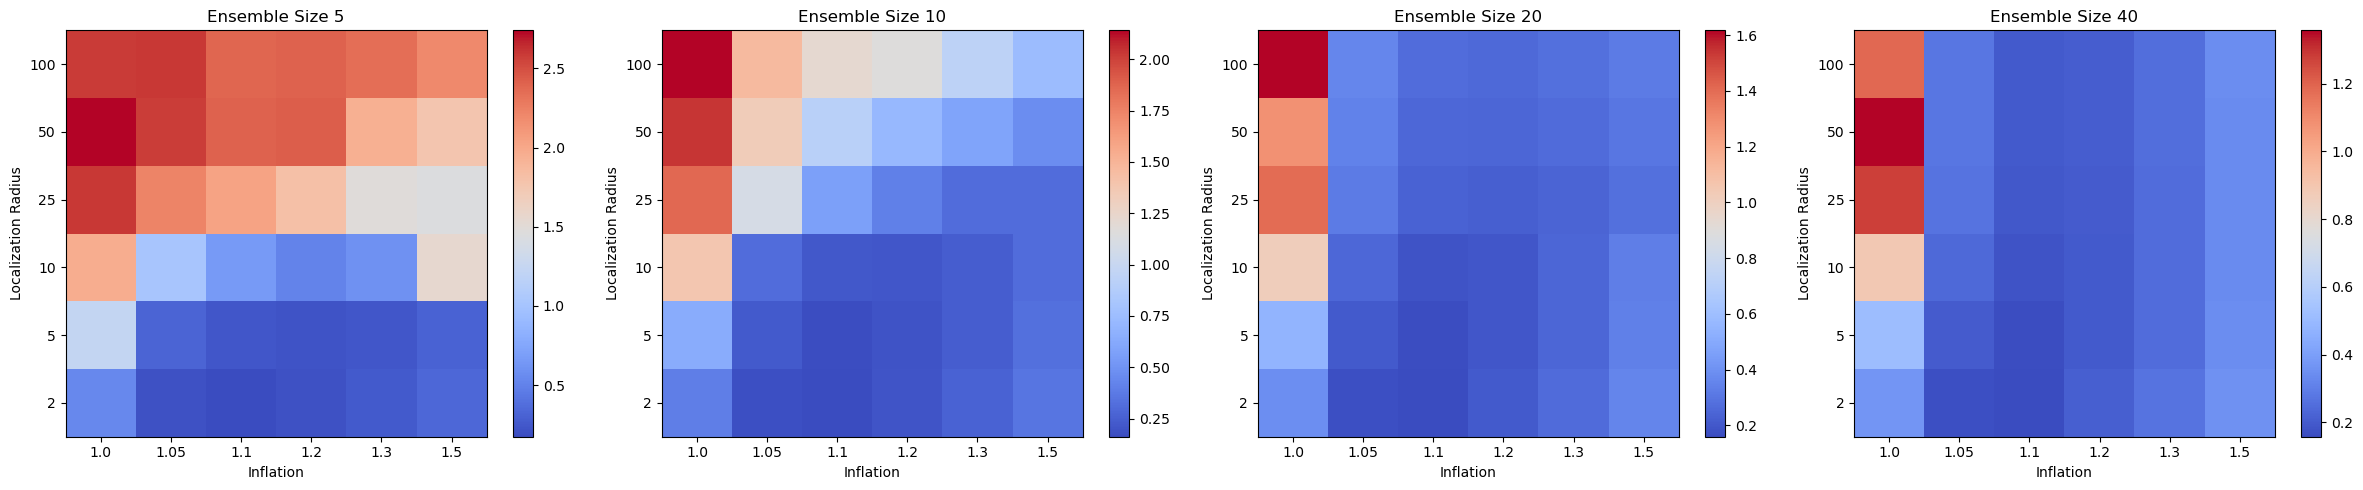

In [18]:
import matplotlib.pyplot as plt
import jax.numpy as jnp


# Calculate total_errors, now considering all inflations but excluding ensemble size 30
total_errors = {(radius, inflation, n_ensemble): jnp.mean(mean_errors[(radius, inflation, n_ensemble)])
                for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes if n_ensemble != 30}

# Adjust the number of ensemble_sizes to plot, excluding 30
ensemble_sizes_to_plot = [n for n in ensemble_sizes if n != 30]
num_ensemble_sizes = len(ensemble_sizes_to_plot)

fig, axs = plt.subplots(1, num_ensemble_sizes, figsize=(num_ensemble_sizes * 6, 5))

# Ensure axs is iterable when there's only one ensemble size to plot
if num_ensemble_sizes == 1:
    axs = [axs]

for idx, n_ensemble in enumerate(ensemble_sizes_to_plot):
    # Skip ensemble size 30
    if n_ensemble == 30:
        continue
    
    # Create a matrix to store total errors for heatmap plotting, adjusting for the excluded ensemble size
    error_matrix = jnp.zeros((len(radii), len(inflations)))

    for i, radius in enumerate(radii):
        for j, inflation in enumerate(inflations):  # Including all inflations
            # Use total_errors, which already excludes ensemble size 30
            error_matrix = error_matrix.at[i, j].set(total_errors.get((radius, inflation, n_ensemble), 0))

    # Plotting
    cax = axs[idx].imshow(error_matrix, cmap='coolwarm', origin='lower', aspect='auto')
    axs[idx].set_title(f'Ensemble Size {n_ensemble}')
    axs[idx].set_xticks(jnp.arange(len(inflations)))
    axs[idx].set_yticks(jnp.arange(len(radii)))
    axs[idx].set_xticklabels(inflations)
    axs[idx].set_yticklabels(radii)
    axs[idx].set_xlabel('Inflation')
    axs[idx].set_ylabel('Localization Radius')

    # Adding colorbar to each subplot
    fig.colorbar(cax, ax=axs[idx], orientation='vertical')

plt.tight_layout()
plt.show()


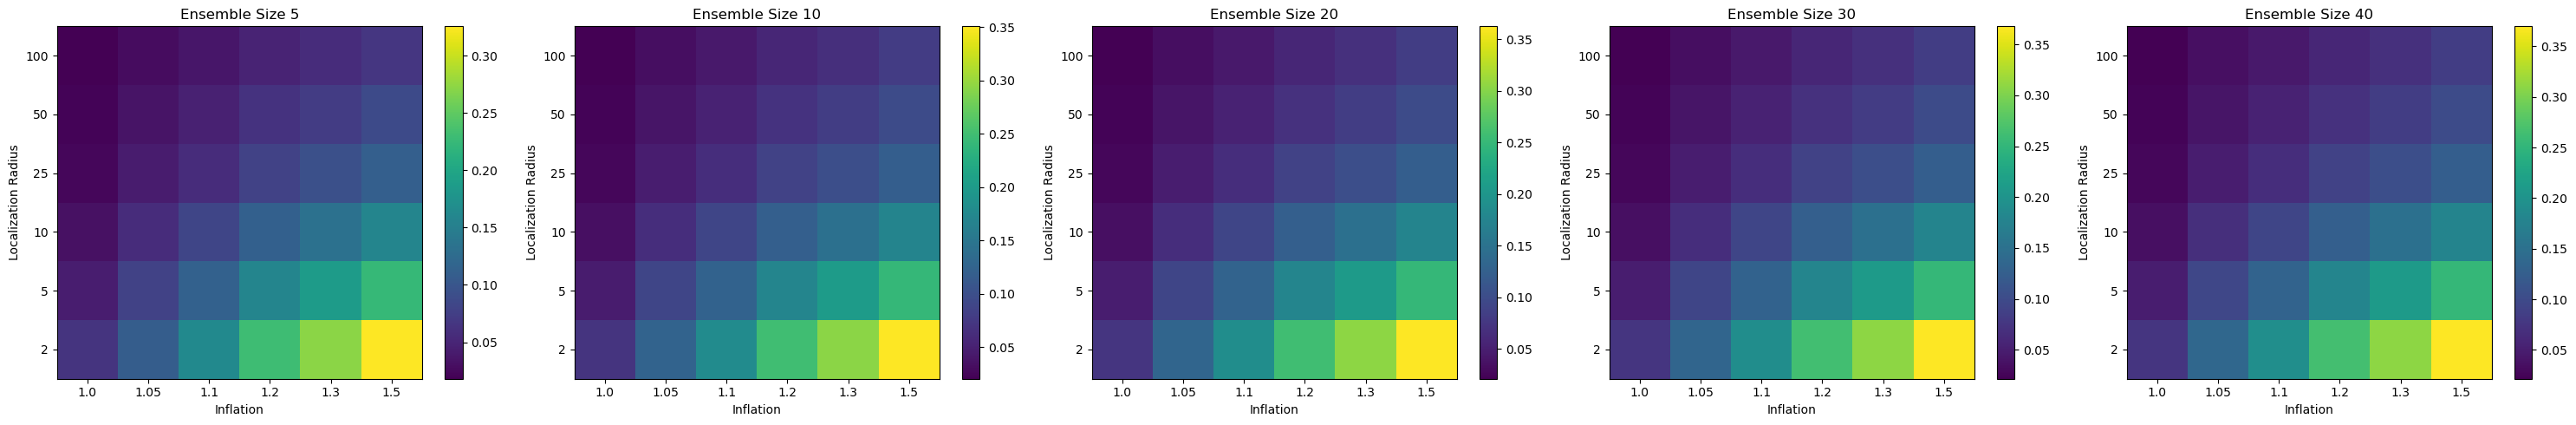

In [6]:

total_std = {(radius, inflation, n_ensemble): jnp.mean(mean_std_errors[(radius, inflation, n_ensemble)]) for radius in radii for inflation in inflations for n_ensemble in ensemble_sizes}

num_ensemble_sizes = len(ensemble_sizes)
fig, axs = plt.subplots(1, num_ensemble_sizes, figsize=(num_ensemble_sizes * 6, 5))

if num_ensemble_sizes == 1:
    axs = [axs]

for idx, n_ensemble in enumerate(ensemble_sizes):
    if n_ensemble == 30:
        continue
    # Create a matrix to store total errors for heatmap plotting
    error_matrix = jnp.zeros((len(radii), len(inflations)))

    for i, radius in enumerate(radii):
        for j, inflation in enumerate(inflations):
            error_matrix = error_matrix.at[i, j].set(total_std[(radius, inflation, n_ensemble)])

    # Plotting
    cax = axs[idx].imshow(error_matrix, cmap='viridis', origin='lower', aspect='auto')
    axs[idx].set_title(f'Ensemble Size {n_ensemble}')
    axs[idx].set_xticks(jnp.arange(len(inflations)))
    axs[idx].set_yticks(jnp.arange(len(radii)))
    axs[idx].set_xticklabels(inflations)
    axs[idx].set_yticklabels(radii)
    axs[idx].set_xlabel('Inflation')
    axs[idx].set_ylabel('Localization Radius')

    # Adding colorbar to each subplot
    fig.colorbar(cax, ax=axs[idx], orientation='vertical')

plt.tight_layout()
plt.show()


In [7]:
import numpy as jnp

# Assuming mean_errors is defined somewhere above
# And radii, inflations, ensemble_sizes are also defined

for radius in radii:
    for inflation in inflations:
        for n_ensemble in ensemble_sizes:
            key = (radius, inflation, n_ensemble)
            data = mean_errors[key]
            num_values = len(data)  # Total number of values
            num_nans = jnp.sum(jnp.isnan(data))  # Count of NaN values
            percent_nans = (num_nans / num_values) * 100  # Percentage of NaN values
            
            print(f"{key}: {percent_nans:.2f}% NaNs")


(2, 1.0, 5): 0.00% NaNs
(2, 1.0, 10): 0.00% NaNs
(2, 1.0, 20): 0.00% NaNs
(2, 1.0, 30): 0.00% NaNs
(2, 1.0, 40): 0.00% NaNs
(2, 1.05, 5): 0.00% NaNs
(2, 1.05, 10): 0.00% NaNs
(2, 1.05, 20): 0.00% NaNs
(2, 1.05, 30): 0.00% NaNs
(2, 1.05, 40): 0.00% NaNs
(2, 1.1, 5): 0.00% NaNs
(2, 1.1, 10): 0.00% NaNs
(2, 1.1, 20): 0.00% NaNs
(2, 1.1, 30): 0.00% NaNs
(2, 1.1, 40): 0.00% NaNs
(2, 1.2, 5): 0.00% NaNs
(2, 1.2, 10): 0.00% NaNs
(2, 1.2, 20): 0.00% NaNs
(2, 1.2, 30): 0.00% NaNs
(2, 1.2, 40): 0.00% NaNs
(2, 1.3, 5): 0.00% NaNs
(2, 1.3, 10): 0.00% NaNs
(2, 1.3, 20): 0.00% NaNs
(2, 1.3, 30): 0.00% NaNs
(2, 1.3, 40): 0.00% NaNs
(2, 1.5, 5): 0.00% NaNs
(2, 1.5, 10): 0.00% NaNs
(2, 1.5, 20): 0.00% NaNs
(2, 1.5, 30): 0.00% NaNs
(2, 1.5, 40): 0.00% NaNs
(5, 1.0, 5): 0.00% NaNs
(5, 1.0, 10): 0.00% NaNs
(5, 1.0, 20): 0.00% NaNs
(5, 1.0, 30): 0.00% NaNs
(5, 1.0, 40): 0.00% NaNs
(5, 1.05, 5): 0.00% NaNs
(5, 1.05, 10): 0.00% NaNs
(5, 1.05, 20): 0.00% NaNs
(5, 1.05, 30): 0.00% NaNs
(5, 1.05, 40): 0.00% NaN